The purpose of this code is to extract a user defined time series <br>
of data from the Copernicus Marine Environmental Service (CMEMS - https://marine.copernicus.eu/) <br>
There are a number of pertinent models covering different areas of Europe at higher resolution <br>
as well as a global model that are needed for global studies <br>
The main models of interest are (to be expanded): <br>
    NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013 0.017 degree x 0.017 degree (33 depth levels) <br>
    NORTHWESTSHELF_ANALYSIS_FORECAST_BIO_004_002_b 0.017 degree x 0.017 degree (33 depth levels) <br>
    IBI_ANALYSIS_FORECAST_PHYS_005_001 0.028 degree x 0.028 degree (50 depth levels) <br>
    IBI_ANALYSIS_FORECAST_BIO_005_004 0.028 degree x 0.028 degree (50 depth levels) <br>
    GLOBAL_ANALYSIS_FORECAST_PHY_001_024 0.083 degree x 0.083 degree (50 depth levels) <br> 
    GLOBAL_ANALYSIS_FORECAST_BIO_001_028 0.083 degree x 0.083 degree (50 depth levels) <br> 


## Note that this depends on motuclient with installation described here:
https://marine.copernicus.eu/faq/can-you-give-a-few-examples-of-command-lines-to-download/

In [1]:

from datetime import datetime, timedelta, date
from urllib.error import URLError, HTTPError
from time import strftime
import netCDF4 as nc

import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import json 
import os

import utils.earth_obs_utils as eo_util

from ipywidgets.embed import embed_minimal_html

with open("./cfg.json") as jfile:
    cfg = json.load(jfile) 

cmems_auth = (cfg['username'], cfg['password'])



In [4]:
def specify_download_extents(user_parameters):
    # We allow it to change for physics or bio 
    # For the low res biology, there is no data closer to shore
    user_parameters['lat_min'] = user_parameters['lat'] # 36.5
    user_parameters['lat_max'] = user_parameters['lat'] # 38.5
    user_parameters['lon_min'] = user_parameters['lon'] # -11
    user_parameters['lon_max'] = user_parameters['lon'] # -8.3
    return user_parameters

def specify_site_parameters(site, phys_file, bio_file, user_parameters):
    if site.lower() == 'sgm':   
        PHYS_FILE = phys_file + '.nc' #'SGM_HIGH_RES_PHYSICS.nc'
        BIO_FILE = bio_file + '.nc'   #'SGM_HIGH_RES_BIOLOGY.nc'
        user_parameters['lon'] = str(-8.883) #  Note that MOTU expects string data
        user_parameters['lat'] = str(37.017) #
    if site.lower() == 'ocean_fresno':
        PHYS_FILE = phys_file + '_OF.nc' #'SGM_HIGH_RES_PHYSICS.nc'
        BIO_FILE = bio_file + '_OF.nc'   #'SGM_HIGH_RES_BIOLOGY.nc'
        user_parameters['lon'] = str(-8.603883) #  Note that MOTU expects string data
        user_parameters['lat'] = str(37.07796) #
    return PHYS_FILE, BIO_FILE, user_parameters

In [5]:
OUTDIR = "./cmems_data/"
train_dir = "./training_data/"

if not os.path.exists(OUTDIR):
   # Create a new directory because it does not exist
   os.makedirs(OUTDIR)
   
if not os.path.exists(train_dir):
   # Create a new directory because it does not exist
   os.makedirs(train_dir)
    
    
user_parameters = dict()
user_parameters['from_date']  =date(2014,8,1).strftime("%Y-%m-%d") ## first data available 
user_parameters['to_date']  =  (datetime.utcnow() - timedelta(days = 10)).strftime("%Y-%m-%d") 
user_parameters['depth_min'] = str(0)   #  \ Again Motu 
user_parameters['depth_max'] = str(1)  #  / expects string


PHYS_FILE, BIO_FILE, user_parameters = specify_site_parameters('sgm',
                                                               'SGM_HIGH_RES_PHYSICS',
                                                              'SGM_HIGH_RES_BIOLOGY',
                                                              user_parameters)
user_parameters = specify_download_extents(user_parameters)

motu_standard = True
## Necessary details on the model and product id for each model
## Generally there is a physical model that generates variables such as temperature, salinity, and current speed
## and biological model that contains variables such as dissolved oxygen and Chl-a
## Each of the physics and biological model have model + product
motu_url = 'http://nrt.cmems-du.eu/motu-web/Motu' # nrt is the pointer for the forecast models
phys_model = 'IBI_ANALYSISFORECAST_PHY_005_001-TDS '
phys_product = 'cmems_mod_ibi_phy_anfc_0.027deg-3D_P1D-m'
bio_model = 'IBI_ANALYSISFORECAST_BGC_005_004-TDS'
bio_product = 'cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m'
debug = True

In [6]:
def variables_to_motu_form(variables):
    '''
    Motu expects vars of form: --variable var_name
    generate that wording from given array of vars
    '''
    variables_str = ""
    for var in variables:
        variables_str += ' --variable ' + str(var)
    return variables_str


### Let's explore the area first
Make plot illustrating the area

In [7]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, Rectangle, Marker
sagres_loc = (user_parameters['lat'], user_parameters['lon'])

watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)

m = Map(layers=(watercolor, ), center=(sagres_loc), zoom=6)

rectangle = Rectangle(bounds=((user_parameters['lat_min'] , user_parameters['lon_min']), 
                              (user_parameters['lat_max'], user_parameters['lon_max'] )))
marker = Marker(location=sagres_loc, draggable=False)

m.add_layer(marker)

m.add_layer(rectangle)

m
#embed_minimal_html('SagresHABDomain.html', views=[m])

Map(center=['37.017', '-8.883'], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [8]:
variables_to_download = ['uo', 'vo', 'thetao', 'zos', 'so', 'mlotst']
## create string of vars we download of form
## '--variable bottomT --variable mlotst --variable so --variable thetao --variable uo --variable vo --variable zos'
variables_str_phys = variables_to_motu_form(variables_to_download)
print(variables_str_phys)
variables_to_download = ['chl', 'dissic', 'fe', 'nh4', 'no3', 'nppv', 'o2', 'ph',
                        'phyc', 'po4', 'si', 'spco2', 'zeu']
variables_str_bio = variables_to_motu_form(variables_to_download)
print(variables_str_bio)

 --variable uo --variable vo --variable thetao --variable zos --variable so --variable mlotst
 --variable chl --variable dissic --variable fe --variable nh4 --variable no3 --variable nppv --variable o2 --variable ph --variable phyc --variable po4 --variable si --variable spco2 --variable zeu


In [9]:
## Now we request the data from motu
call_status, call_txt = eo_util.download_variable_from_motu(phys_model, phys_product, motu_url,
                                                            user_parameters, variables_str_phys, 
                                    OUTDIR, PHYS_FILE, cmems_auth)
call_status

'2023-03-28 13:32:23.263 [ INFO] Asynchronous mode set\n2023-03-28 13:32:23.263 [ INFO] Authenticating user fodonncha for service http://nrt.cmems-du.eu/motu-web/Motu\n2023-03-28 13:32:26.840 [ INFO] Requesting file to download (this can take a while)...\n2023-03-28 13:32:32.950 [ INFO] Authenticating user fodonncha for service https://nrt.cmems-du.eu/motu-web/Motu\n2023-03-28 13:32:41.407 [ INFO] Product is not yet available (request in progress)\n2023-03-28 13:32:51.412 [ INFO] Authenticating user fodonncha for service https://nrt.cmems-du.eu/motu-web/Motu\n2023-03-28 13:33:00.728 [ INFO] Product is not yet available (request in progress)\n2023-03-28 13:33:10.733 [ INFO] Authenticating user fodonncha for service https://nrt.cmems-du.eu/motu-web/Motu\n2023-03-28 13:33:19.457 [ INFO] Product is not yet available (request in progress)\n2023-03-28 13:33:29.460 [ INFO] Authenticating user fodonncha for service https://nrt.cmems-du.eu/motu-web/Motu\n2023-03-28 13:33:38.461 [ INFO] Product 

### Do the same for biology

In [10]:
call_status, call_txt = eo_util.download_variable_from_motu(bio_model, bio_product, motu_url,
                                          user_parameters, variables_str_bio, 
                                          OUTDIR, BIO_FILE, cmems_auth)

### Have a look at reading the data to see how it looks


(736,) (736,) (736,)


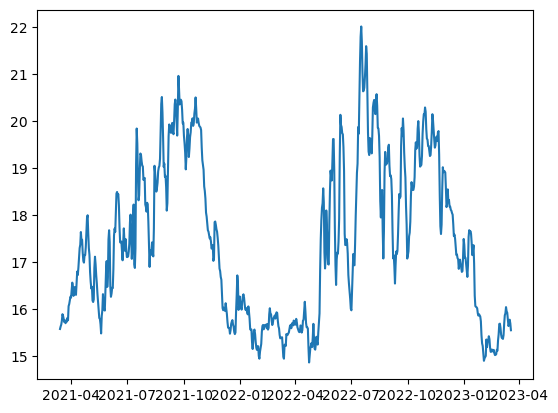

In [11]:
def read_dimensions_from_ncfile(filename):
    dataset_nc = nc.Dataset(filename)
    lat = dataset_nc.variables['latitude'][:]
    lon = dataset_nc.variables['longitude'][:]
    time = dataset_nc.variables['time']
    time_convert = nc.num2date(time[:], time.units, time.calendar, 
                               only_use_cftime_datetimes=False,
                               only_use_python_datetimes=True)
    return lat, lon, time_convert

fname_read = OUTDIR + PHYS_FILE
lat, lon, time = read_dimensions_from_ncfile(fname_read)
dataset_nc = nc.Dataset(fname_read)
temp = dataset_nc.variables['thetao'][:,0,0,0]
uo = dataset_nc.variables['uo'][:,0,0,0]
vo = dataset_nc.variables['vo'][:,0,0,0]
print(temp.shape, uo.shape, vo.shape)
plt.plot(time, temp)

(1,) (1,) (1,) (1,) (736,)


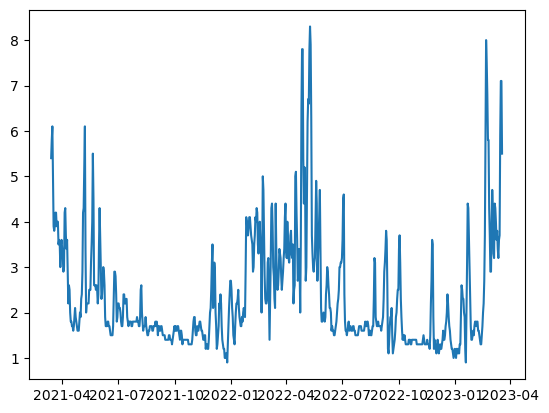

In [12]:
fname_read = OUTDIR + BIO_FILE
lat_bio, lon_bio, time_bio = read_dimensions_from_ncfile(fname_read)
dataset_nc = nc.Dataset(fname_read)
#temp_bio = dataset_nc.variables['thetao'][:,0,:,:]
#uo = dataset_nc.variables['uo'][:,0,:,:]
#vo = dataset_nc.variables['vo'][:,0,:,:]

nppv = dataset_nc.variables['nppv'][:,0,0,0] # "net_primary_production_of_biomass_expressed_as_carbon_per_unit_volume_in_sea_water"
chl = dataset_nc.variables['chl'][:,0,0,0] # "mass_concentration_of_chlorophyll_a_in_sea_water"
o2 = dataset_nc.variables['o2'][:,0,0,0] # "mole_concentration_of_dissolved_molecular_oxygen_in_sea_water"
zeu = dataset_nc.variables['zeu'][:,0,0] # euphotic_zone_depth
phyc = dataset_nc.variables['phyc'][:,0,0,0] # "millimoles of Phytoplankton Carbon per cubic meter"
print(lat.shape, lon.shape, lat_bio.shape, lon_bio.shape, phyc.shape)
plt.plot(time, phyc)

In [13]:
time[0].strftime("%Y-%m-%d")

'2021-03-13'

### Step 2: We have limited time period from the main file so need to also extract from reanalysis files

In [14]:
motu_url = 'http://my.cmems-du.eu/motu-web/Motu'  # my.cmems is the pointer for the historical reanalysis data
phys_model = 'IBI_MULTIYEAR_PHY_005_002-TDS'
phys_product = 'cmems_mod_ibi_phy_my_0.083deg-3D_P1D-m'
bio_model = 'IBI_MULTIYEAR_BGC_005_003-TDS'
bio_product = 'cmems_mod_ibi_bgc_my_0.083deg-3D_P1D-m'

PHYS_FILE = 'SGM_LOW_RES_PHYSICS.nc'
BIO_FILE = 'SGM_LOW_RES_BIOLOGY.nc'
user_parameters['from_date']  =  date(2014,5,1).strftime("%Y-%m-%d") ## I think we can just set this an arbitrary long period
user_parameters['to_date']  =  time[1].strftime("%Y-%m-%d") ## last available reanalysis data
 #The date range is invalid. Invalid date range: [2020-08-01 00:00:00,2021-02-26 23:59:59]. 
 #   Valid range is: [1993-01-01 12:00:00,2019-12-24 12:00:00].

In [15]:
## Now we request the data from motu
call_status, call_txt = eo_util.download_variable_from_motu(phys_model, phys_product, motu_url,
                                                            user_parameters, variables_str_phys, 
                                    OUTDIR, PHYS_FILE, cmems_auth)
call_status


'2023-03-28 13:48:08.008 [ INFO] Asynchronous mode set\n2023-03-28 13:48:08.008 [ INFO] Authenticating user fodonncha for service http://my.cmems-du.eu/motu-web/Motu\n2023-03-28 13:48:10.201 [ INFO] Requesting file to download (this can take a while)...\n2023-03-28 13:48:16.345 [ INFO] Authenticating user fodonncha for service https://my.cmems-du.eu/motu-web/Motu\n2023-03-28 13:48:24.987 [ INFO] Product is not yet available (request in progress)\n2023-03-28 13:48:34.989 [ INFO] Authenticating user fodonncha for service https://my.cmems-du.eu/motu-web/Motu\n2023-03-28 13:48:43.098 [ INFO] Product is not yet available (request in progress)\n2023-03-28 13:48:53.103 [ INFO] Authenticating user fodonncha for service https://my.cmems-du.eu/motu-web/Motu\n2023-03-28 13:49:00.164 [ INFO] Product is not yet available (request in progress)\n2023-03-28 13:49:10.169 [ INFO] Authenticating user fodonncha for service https://my.cmems-du.eu/motu-web/Motu\n2023-03-28 13:49:17.345 [ INFO] Product is no

In [16]:
## Now we request the data from motu
call_status, call_txt = eo_util.download_variable_from_motu(phys_model, phys_product, motu_url,
                                                            user_parameters, variables_str_phys, 
                                    OUTDIR, PHYS_FILE, cmems_auth)
## The biological data is coarser and there is no data close to shore
user_parameters['lon'] = str(float(user_parameters['lon']) + 0.1) #  Note that MOTU expects string data
user_parameters['lat'] = str(float(user_parameters['lat']) - 0.1) #

call_status, call_txt = eo_util.download_variable_from_motu(bio_model, bio_product, motu_url,
                                          user_parameters, variables_str_bio, 
                                          OUTDIR, BIO_FILE, cmems_auth)

(1,) (1,) (1,) (1,)


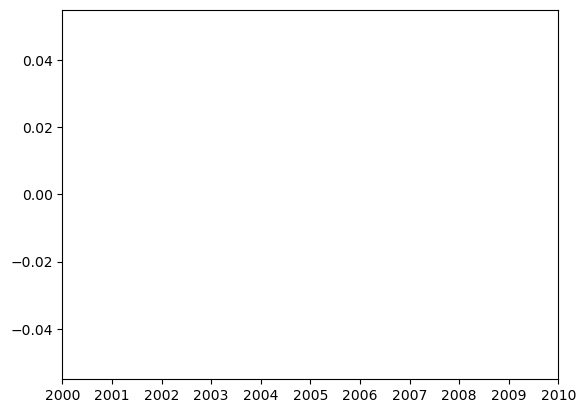

In [17]:
fname_read = OUTDIR + BIO_FILE
lat_bio, lon_bio, time_bio = read_dimensions_from_ncfile(fname_read)
dataset_nc = nc.Dataset(fname_read)
#temp_bio = dataset_nc.variables['thetao'][:,0,:,:]
#uo = dataset_nc.variables['uo'][:,0,:,:]
#vo = dataset_nc.variables['vo'][:,0,:,:]

nppv = dataset_nc.variables['nppv'][:,0,0,0] # "net_primary_production_of_biomass_expressed_as_carbon_per_unit_volume_in_sea_water"
chl = dataset_nc.variables['chl'][:,0,0,0] # "mass_concentration_of_chlorophyll_a_in_sea_water"
o2 = dataset_nc.variables['o2'][:,0,0,0] # "mole_concentration_of_dissolved_molecular_oxygen_in_sea_water"
zeu = dataset_nc.variables['zeu'][:,0,0] # euphotic_zone_depth
phyc = dataset_nc.variables['phyc'][:,0,0,0] # "millimoles of Phytoplankton Carbon per cubic meter"
print(lat.shape, lon.shape, lat_bio.shape, lon_bio.shape)
plt.plot(time_bio, phyc)


## Combine data and dump to csv

In [18]:


def read_dimensions_from_ncfile(filename):
    dataset_nc = nc.Dataset(filename)
    lat = dataset_nc.variables['latitude'][:]
    lon = dataset_nc.variables['longitude'][:]
    time = dataset_nc.variables['time']
    time_convert = nc.num2date(time[:], time.units, time.calendar, 
                               only_use_cftime_datetimes=False,
                               only_use_python_datetimes=True)
    df = pd.DataFrame(pd.to_datetime(time_convert), columns=['time'])
    df['time'] = df['time'].apply(lambda x: x.date())
    ## for some reason they are flipped so newest data point is first
    ## change into more traditional time series representation
 #   df = df.iloc[::-1]
    return lat, lon, df

def get_from_file(ncfile, key):
    var = ncfile[key]
    if len(var.shape) == 1: # Latitude, longitude, ...
        var = var[0]  
    if len(var.shape) == 2: # I don't think these exist
        var = var[:, 0]  
    if len(var.shape) == 3: # These are 2D arrays such as water elevation
        var = var[:,0,0]
    if len(var.shape) == 4: # These are 3D arrays such as temperature, salinit, etc
        var = var[:,0,0,0]
    return var

def read_netcdf_file(fname):
    lat, lon, df = read_dimensions_from_ncfile(fname)
    ncfile = nc.Dataset(fname)
    for key in ncfile.variables.keys():
        ts = get_from_file(ncfile, key)
        if len(ts.shape) > 0: # latitude, longitude, etc. let's just not add
            df_ = pd.DataFrame(ts, columns=[key])
            df[key] = df_[key]
    df.set_index('time', inplace=True)
    return lat, lon, df
        
def join_high_low_res(high_res_fname, low_res_fname):
    lat_hr, lon_hr, df_hr = read_netcdf_file(high_res_fname)
    lat_lr, lon_lr, df_lr = read_netcdf_file(low_res_fname)
    df_lr = df_lr.loc[(df_lr.index < df_hr.index[0])] # We want to take low res data from when high res no longer available
    df_merged = pd.concat([df_hr[::-1], df_lr[::-1]], ignore_index=False, axis =0)
    return df_merged

In [19]:
cmems_dir = 'cmems_data/' # can set this to './' if in same dir

df_physics = join_high_low_res(cmems_dir + 'SGM_HIGH_RES_PHYSICS.nc', 
                             cmems_dir + 'SGM_LOW_RES_PHYSICS.nc')
  

In [20]:
df_biology = join_high_low_res(cmems_dir + 'SGM_HIGH_RES_BIOLOGY.nc', 
                             cmems_dir + 'SGM_LOW_RES_BIOLOGY.nc')


<AxesSubplot:xlabel='time'>

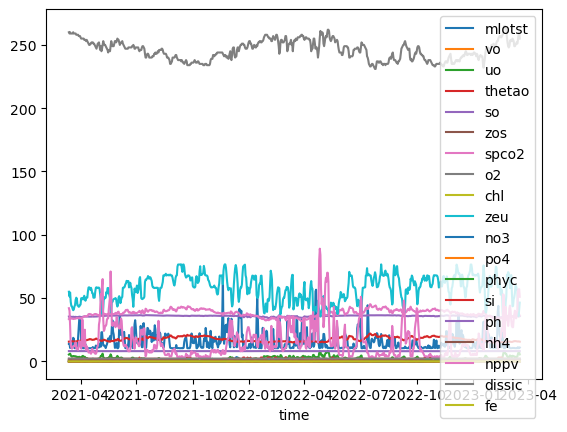

In [21]:
df_all = pd.merge(df_physics, df_biology, left_index=True, right_index=True)
df_all.plot()

In [22]:
df_all.to_csv('./training_data/ocean_fresno_habs_matrices.csv', index=True)